## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


И в том, и в другом случае мы генерируем рекомендации на основе похожести друг на друга, либо пользователей, либо товаров. Функцию использовать вполне получится, принцип работы один и тот же.
По сравнению с ALS, в Item-Item преимущество будет за более популярными объектами, редкие же не будут попадать в рекомендации. Если говорить о механике работы, то основным отличием будет количество скрытых факторов, вычисляемых для объекта, в Item-Item он один, в ALS - по желанию автора.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


* Средняя оценка пользователей
* Была ли повторная покупка товара
* Факт нахождения в избранном

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


* Проблема "холодных" пользователей до сих пор остается нерешенной.
* При обычном разложении матриц нас бы не смутили негативные значения в них, однако при "промышленном" использовании их принято обнулять, т.к. негативные значения не имеют под собой физического обоснования быть таковыми.

## Практическая часть


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares

# Функции из 1-ого вебинара
import os, sys
import time

In [ ]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [ ]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)]
    return res

In [ ]:
def get_ids(user_item_matrix):
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
    return itemid_to_id, userid_to_id, id_to_itemid

In [ ]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [ ]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

c:\dev\geekbrains\venv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [ ]:
recs_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
recs_train.columns=['user_id', 'actual']

recs_val = data_test.groupby('user_id')['item_id'].unique().reset_index()
recs_val.columns=['user_id', 'actual']

result = pd.DataFrame(index=['train', 'val'])

In [ ]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват другие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

model = AlternatingLeastSquares(factors=10, 
                                regularization=0.001,
                                iterations=10, 
                                calculate_training_loss=True, 
                                use_gpu=False)
model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=False)

itemid_to_id, userid_to_id, id_to_itemid = get_ids(user_item_matrix)

recs_train['quantity'] = recs_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.loc['train', 'quantity'] = recs_train.apply(lambda row: precision_at_k(row['quantity'], row['actual']), axis=1).mean()
recs_val['quantity'] = recs_val['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.loc['val', 'quantity'] = recs_val.apply(lambda row: precision_at_k(row['quantity'], row['actual']), axis=1).mean()

In [ ]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробоват другие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

model = AlternatingLeastSquares(factors=10, 
                                regularization=0.001,
                                iterations=10, 
                                calculate_training_loss=True, 
                                use_gpu=False)
model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=False)

itemid_to_id, userid_to_id, id_to_itemid = get_ids(user_item_matrix)

recs_train['sum'] = recs_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.loc['train', 'sum'] = recs_train.apply(lambda row: precision_at_k(row['sum'], row['actual']), axis=1).mean()
recs_val['sum'] = recs_val['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.loc['val', 'sum'] = recs_val.apply(lambda row: precision_at_k(row['sum'], row['actual']), axis=1).mean()

In [ ]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values=['sales_value','retail_disc'], # Можно пробоват другие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = (user_item_matrix.retail_disc+user_item_matrix.sales_value).astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

model = AlternatingLeastSquares(factors=10, 
                                regularization=0.001,
                                iterations=10, 
                                calculate_training_loss=True, 
                                use_gpu=False)
model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=False)

itemid_to_id, userid_to_id, id_to_itemid = get_ids(user_item_matrix)

recs_train['sum_disc'] = recs_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.loc['train', 'sum_disc'] = recs_train.apply(lambda row: precision_at_k(row['sum_disc'], row['actual']), axis=1).mean()
recs_val['sum_disc'] = recs_val['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.loc['val', 'sum_disc'] = recs_val.apply(lambda row: precision_at_k(row['sum_disc'], row['actual']), axis=1).mean()

In [ ]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='basket_id', # Можно пробоват другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

model = AlternatingLeastSquares(factors=10, 
                                regularization=0.001,
                                iterations=10, 
                                calculate_training_loss=True, 
                                use_gpu=False)
model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=False)

itemid_to_id, userid_to_id, id_to_itemid = get_ids(user_item_matrix)

recs_train['orders'] = recs_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.loc['train', 'orders'] = recs_train.apply(lambda row: precision_at_k(row['orders'], row['actual']), axis=1).mean()
recs_val['orders'] = recs_val['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.loc['val', 'orders'] = recs_val.apply(lambda row: precision_at_k(row['orders'], row['actual']), axis=1).mean()

In [ ]:
result.T

,train,val
quantity,0.603121,0.171988
sum,0.535254,0.143487
sum_disc,0.530292,0.153379
orders,0.619768,0.188834


Неплохой результат на обучающей выборке показал подход с количеством купленного товара (сумма по quantity), на валидационной лучше результат по количеству заказов с конкретным товаром. Из этих двух метрик (на обучающей и на валидационной) предпочтение стоит отдать валидационной, т.к. этих данных модель не видела, а значит её результат в реальных условиях оказался лучше.
Результат, кстати, весьма неплохой уже сейчас, без подбора параметров, считай 1 из 5 мы почти уверенно угадываем.

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [ ]:
# матрицу пересоздавать не будем - нужная нам как раз была последней

factors = [2, 5, 10, 30]
regs = [0.01, 0.005, 0.001]
result = pd.DataFrame(index=pd.MultiIndex.from_product([factors, regs], names=['factors', 'lambda']), 
                      columns=['time', 'train', 'val'])
c = 0
for f in factors:
    for r in regs:
        c += 1
        model = AlternatingLeastSquares(factors=f, 
                                regularization=r,
                                iterations=100, 
                                calculate_training_loss=True, 
                                use_gpu=False,
                                       )
        time_start = time.time()
        model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
                  show_progress=False)
        time_finish = time.time()
        
        result.loc[(f, r), 'time'] = time_finish - time_start

        recs_train[f'{f}_{r}'] = recs_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        result.loc[(f, r), 'train'] = recs_train.apply(lambda row: precision_at_k(row[f'{f}_{r}'], row['actual']), axis=1).mean()
        recs_val[f'{f}_{r}'] = recs_val['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        result.loc[(f, r), 'val'] = recs_val.apply(lambda row: precision_at_k(row[f'{f}_{r}'], row['actual']), axis=1).mean()
        print(f"\r{c*'+'}{(result.shape[0]-c)*'.'}", end='')

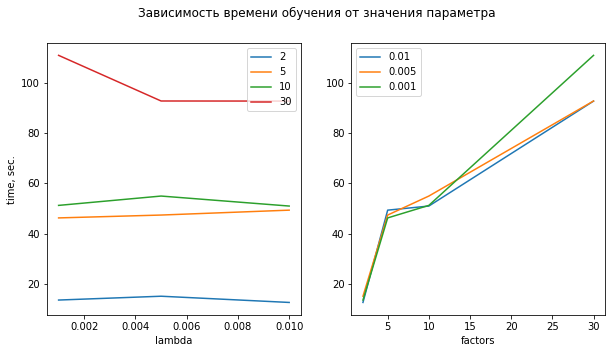

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Зависимость времени обучения от значения параметра')
ax1.set_xlabel('lambda')
ax1.set_ylabel('time, sec.')
ax2.set_xlabel('factors')
for f in factors:
    ax1.plot(result.loc[f]['time'], label=f)
for r in regs:
    ax2.plot(result.loc[(slice(None), r), 'time'].reset_index(level=1, drop=True), label=r)
ax1.legend()
ax2.legend()

Наиболее сильное влияние на скорость обучения оказывает параметр количества факторов, что вполне объяснимо, т.к. он делает матрицы больше и все вычисления идут дольше. Параметр регуляризации якобы немного снижает время обучения на моделях с большим количеством факторов. Поведение моделей на 10 факторов сложно оценить рационально, они почему-то выпали из общего тренда.

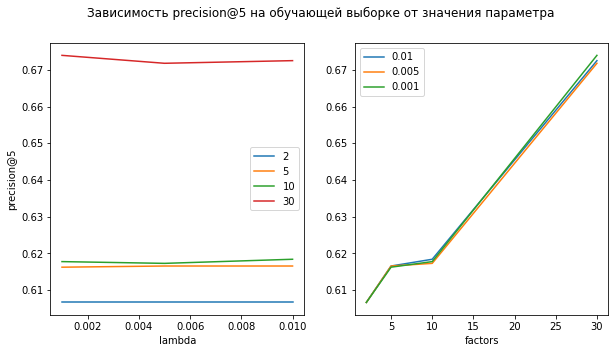

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Зависимость precision@5 на обучающей выборке от значения параметра')
ax1.set_xlabel('lambda')
ax1.set_ylabel('precision@5')
ax2.set_xlabel('factors')
for f in factors:
    ax1.plot(result.loc[f]['train'], label=f)
for r in regs:
    ax2.plot(result.loc[(slice(None), r), 'train'].reset_index(level=1, drop=True), label=r)
ax1.legend()
ax2.legend()

Регуляризация, ожидаемо, не оказывает никакого влияния на показатель precision, при обучении же по мере увеличения кол-ва факторов он растет - скорее всего из-за переобучения. На 10-факторных и здесь какая-то аномалия, видимо, зависимость носит нелинейный характер.

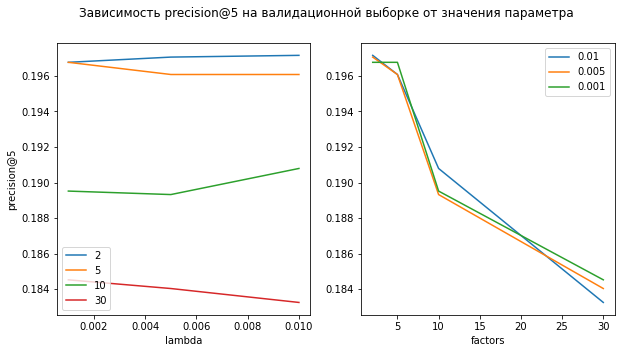

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Зависимость precision@5 на валидационной выборке от значения параметра')
ax1.set_xlabel('lambda')
ax1.set_ylabel('precision@5')
ax2.set_xlabel('factors')
for f in factors:
    ax1.plot(result.loc[f]['val'], label=f)
for r in regs:
    ax2.plot(result.loc[(slice(None), r), 'val'].reset_index(level=1, drop=True), label=r)
ax1.legend()
ax2.legend()

Наилучший результат показывают самые простые модели, видимо, на большем количестве факторов происходит переобучение.

In [ ]:
result.sort_values('val').iloc[-1]

time     12.606307
train     0.606643
val        0.19716
Name: (2, 0.01), dtype: object

В результате, наилучшей моделью оказалась модель на основе количества заказов с определенным товаром, 2 фактора с лямбдой 0.01. Она простая, быстро учится и работает, и результаты на валидационной выборке показывает лучше прочих, угадывая 1 из 5 рекомендованых товаров (т.к. precision близок к 1/5)